# DESAFIO ONCASE QUESTÃO 3 MODELAGEM

---

NOME: ÍCARO JOSIAS FERREIRA PAIVA

EMAIL: ijfp@cin.ufpe.br

3. Construa um regressor e identifique quais variáveis exercem maior impacto sobre o “target” e informe o porquê interpretando os resultados obtidos. 

> a. métricas: RMSE, R2 e cor(target_observado, target_predito);

> b. dados: regression_data.zip.

## 0 IMPORTAÇÃO

### 0.1 IMPORTAR BIBLIOTECAS

In [1]:
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import xgboost                 as xgb

from sklearn.model_selection   import train_test_split, RepeatedKFold, GridSearchCV, cross_validate
from xgboost                   import XGBRegressor
from sklearn.metrics           import mean_squared_error, r2_score, make_scorer

### 0.2 IMPORTAR DADOS

In [2]:
# conjunto de treinamento

df_raw_train = pd.read_csv('/content/drive/MyDrive/DESAFIO/ONCASE/regression_train.csv')

In [3]:
df_raw_train.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680


In [4]:
# conjunto de teste

df_raw_test = pd.read_csv('/content/drive/MyDrive/DESAFIO/ONCASE/regression_test.csv')

In [5]:
df_raw_test.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,3.436244,0.210854,-2.451307,51.239996,4.641751,-67.874319,5,-5.760571
1,1525.839412,2.157483,4.337776,43.828794,8.070219,-68.405526,8,10.193773
2,455.600191,5.166359,-0.452615,43.931305,1.349625,-66.240021,0,-1.063645
3,0.619759,3.276641,-3.607201,50.631046,2.473542,-69.971690,8,-8.476921
4,10.996472,-1.867485,-2.408863,58.660224,2.826219,-53.647149,5,-5.660827


## 1 EXPLORAÇÃO DOS DADOS

### 1.1 DESCRIÇÃO DOS DADOS

In [6]:
df_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  715 non-null    float64
 1   X1      1042 non-null   float64
 2   X2      1031 non-null   float64
 3   X3      1042 non-null   float64
 4   X4      1042 non-null   float64
 5   X5      1042 non-null   float64
 6   X6      1042 non-null   int64  
 7   X7      1042 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 65.2 KB


In [7]:
df_raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  180 non-null    float64
 1   X1      261 non-null    float64
 2   X2      261 non-null    float64
 3   X3      261 non-null    float64
 4   X4      261 non-null    float64
 5   X5      261 non-null    float64
 6   X6      261 non-null    int64  
 7   X7      261 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 16.4 KB


Existe elementos faltantes em algumas variaveis do Conjunto de Treinamento e Teste.

Tratamento dos NA (dados faltantes)

In [8]:
# identificação dos variaveis com dados faltantes, quantidade e percentual no Conjunto Treinamento

for i in range(len(df_raw_train.columns)):
    print('%s possui %i de dados faltantes (%0.2f do total)'%((df_raw_train.isna().sum().index)[i],(df_raw_train.isna().sum())[i],(df_raw_train.isna().sum()/len(df_raw_train))[i]))

target possui 327 de dados faltantes (0.31 do total)
X1 possui 0 de dados faltantes (0.00 do total)
X2 possui 11 de dados faltantes (0.01 do total)
X3 possui 0 de dados faltantes (0.00 do total)
X4 possui 0 de dados faltantes (0.00 do total)
X5 possui 0 de dados faltantes (0.00 do total)
X6 possui 0 de dados faltantes (0.00 do total)
X7 possui 0 de dados faltantes (0.00 do total)


In [9]:
# identificação dos variaveis com dados faltantes, quantidade e percentual no Conjunto Teste

for i in range(len(df_raw_train.columns)):
    print('%s possui %i de dados faltantes (%0.2f do total)'%((df_raw_train.isna().sum().index)[i],(df_raw_test.isna().sum())[i],(df_raw_test.isna().sum()/len(df_raw_test))[i]))

target possui 81 de dados faltantes (0.31 do total)
X1 possui 0 de dados faltantes (0.00 do total)
X2 possui 0 de dados faltantes (0.00 do total)
X3 possui 0 de dados faltantes (0.00 do total)
X4 possui 0 de dados faltantes (0.00 do total)
X5 possui 0 de dados faltantes (0.00 do total)
X6 possui 0 de dados faltantes (0.00 do total)
X7 possui 0 de dados faltantes (0.00 do total)


Por se tratar da variável target a estrategia usada será excluir os valores faltantes para não enviezar os treinamento e resultados.

In [10]:
# Tratamento dos NA (dados faltantes) no conjunto de treinamento
df_train = df_raw_train.copy()
df_train = df_train.dropna(subset=['target'])

In [11]:
# identificação dos variaveis com dados faltantes no Conjunto de Treinamento

df_train.isna().sum()

target    0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
dtype: int64

In [12]:
# Tratamento dos NA (dados faltantes) no conjunto de teste

df_test = df_raw_test.copy()
df_test = df_test.dropna(subset=['target'])

In [13]:
# identificação dos variaveis com dados faltantes no Conjunto de Teste

df_test.isna().sum()

target    0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
dtype: int64

conjunto de dados (treino e teste) sem dados faltantes

### 1.2 AVALIAÇÃO DAS VARIÁVEIS

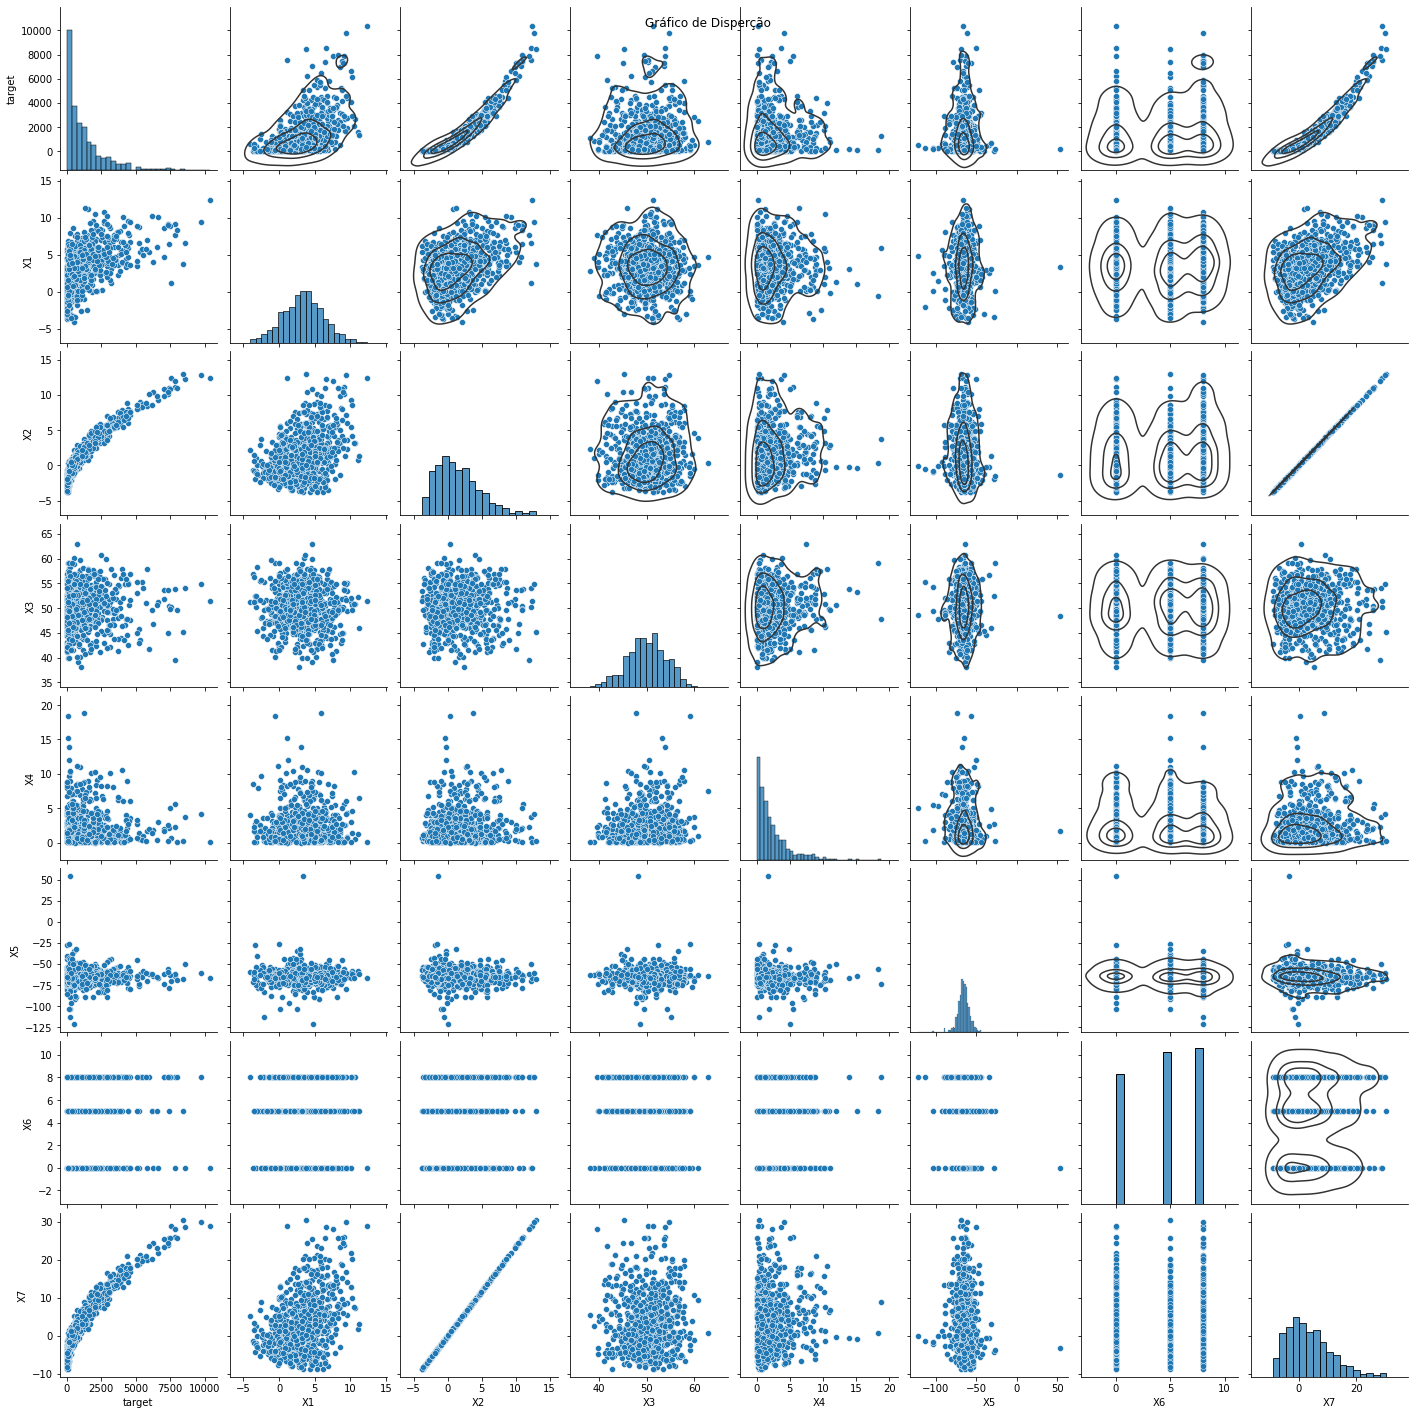

In [14]:
# Gráfico de Disperção

g = sns.pairplot(data=df_train, kind="scatter", palette="deep")
g.map_upper(sns.kdeplot, levels=4, color=".2")
g.fig.suptitle('Gráfico de Disperção');

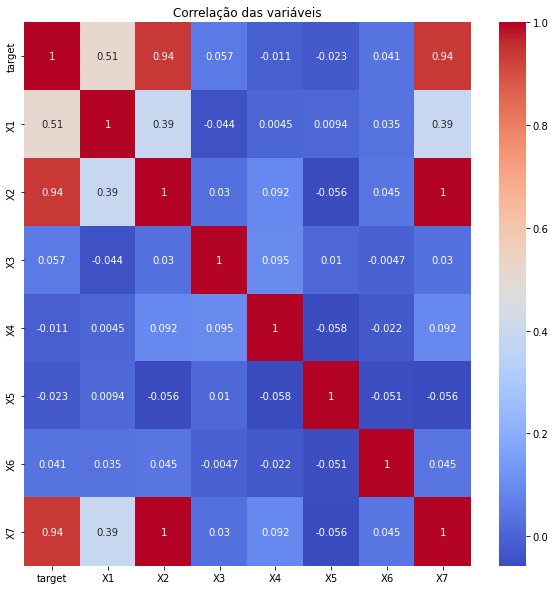

In [33]:
# Correlação das váriáveis

corr_matrix = df_train.corr()

plt.figure(figsize=(10, 10))
plt.title('Correlação das variáveis')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

As variáveis X1, X2 e X7 apresentam alto grau de correlação (maior que 0.5) com a variável target. As outras variáveis apresentaram valores despresíveis (próximos a zero) o que torna elas potencial para serem excluidas do modelo.

## 2 PREPARAÇÃO DOS DADOS

### 2.1 SELEÇÃO DAS VARIÁVEIS

In [16]:
filtro = corr_matrix[corr_matrix['target'] >= 0.3]
variaveis = filtro['target'].index
print('As seguintes variáveis possuem mais que 0.3 de correlação com a variavel target \n e serão usadas para o modelo: ', list(variaveis))

As seguintes variáveis possuem mais que 0.3 de correlação com a variavel target 
 e serão usadas para o modelo:  ['target', 'X1', 'X2', 'X7']


In [17]:
df_train2 = df_train[variaveis]
df_train2.head()

,target,X1,X2,X7
1,47.735389,3.074317,-2.836000,-6.664599
3,908.202209,6.907396,-0.308967,-0.726072
4,1640.461863,1.916788,3.460290,8.131680
5,750.197635,1.090232,1.256970,2.953880
6,1042.939629,1.145275,2.354394,5.532825


In [18]:
df_test2 = df_test[variaveis]
df_test2.head()

,target,X1,X2,X7
0,3.436244,0.210854,-2.451307,-5.760571
1,1525.839412,2.157483,4.337776,10.193773
2,455.600191,5.166359,-0.452615,-1.063645
3,0.619759,3.276641,-3.607201,-8.476921
4,10.996472,-1.867485,-2.408863,-5.660827


### 2.2 DIVISÃO TREINO, VALIDAÇÃO E TESTE

In [19]:
# Separação do target no Conjunto de Treinamento

X = df_train2.drop('target', axis =1)
y = df_train2['target']

In [20]:
# divisão entre Conjunto treino e validação

size_test = 0.25
seed = 34

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=size_test, random_state=seed)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((536, 3), (179, 3), (536,), (179,))

In [21]:
# Separação do target para Conjunto de Teste


X_test = df_test2.drop('target', axis =1)
y_test = df_test2['target']
X_test.shape, y_test.shape

((180, 3), (180,))

## 3 MODELO

### 3.1 BUSCA DE HIPERPARAMETROS

In [22]:
# Métricas de avaliação para o modelo

mse = make_scorer(mean_squared_error,greater_is_better=False)
r2 = make_scorer(r2_score,greater_is_better=True)

scoring = {'mse': mse,
           'r2': r2}

In [23]:
# Definindo hiperparametros e regressor

model_xgb = xgb.XGBRegressor()
param = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
       }

# Inicializando busca paramentros
gs_xgb = GridSearchCV(estimator=model_xgb, 
                      param_grid= param, 
                      cv=4, n_jobs=-1, verbose=1, scoring = mse)

# Busca dos hiperparamentros
gs_xgb.fit(X_train, y_train)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=4, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=1)

In [24]:
# Treinamento do modelo

reg_xgb = gs_xgb.best_estimator_
reg_xgb.fit(X_train, y_train)

[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=1.0, gamma=0.5, subsample=0.8)

In [25]:
#Paramentros do modelo

reg_xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1.0,
 'gamma': 0.5,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

### 3.2 VALIDAÇÃO CRUZADA

In [26]:
# Definições do Kfold para cross validation

rkf = RepeatedKFold(n_splits=4, n_repeats=4, random_state=1234)

In [27]:
# cross validation no Conjunto de Validação

cv_scores_xgb = cross_validate(reg_xgb, X_val, y_val, cv=rkf, scoring=scoring)

[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [28]:
val_rmse = np.sqrt(np.abs(cv_scores_xgb['test_mse']))

print('No Conjunto de Validação o valor médio do RMSE é de %0.2f +/- %0.2f' % (val_rmse.mean(), val_rmse.std()))

No Conjunto de Validação o valor médio do RMSE é de 251.93 +/- 113.50


In [29]:
val_r2 = cv_scores_xgb['test_r2']

print('No Conjunto de Validação o valor médio do R2 é de %0.2f +/- %0.2f' % (val_r2.mean(), val_r2.std()))

No Conjunto de Validação o valor médio do R2 é de 0.98 +/- 0.01


Os resultados do modelo para o conjunto de validação são satisfatórios. Assim, podemos avançar para o resultados no Conjunto de Teste 

## 4 RESULTADOS

In [30]:
#Previsão para o Conjunto de Teste

y_pred = reg_xgb.predict(X_test)

In [31]:
print('Para o Conjunto de Teste o  temos RMSE: %.2f e R2: %0.2f' %(mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)))

Para o Conjunto de Teste o  temos RMSE: 163.00 e R2: 0.98


[]

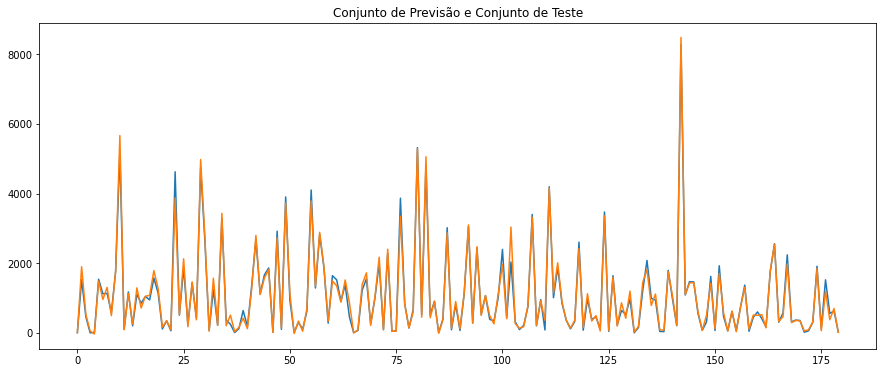

In [32]:
# plot da previsão e teste

fig, ax1 = plt.subplots(figsize=(15,6))
plt.title('Conjunto de Previsão e Conjunto de Teste')
plt.plot(np.array(y_test))
plt.plot(y_pred)
plt.plot()

Podemos ver pelas metricas de erro RMSE e R2 e a ferramenta visual(gráfico) que tivemos previsões boas mostrando que o modelo foi capaz de aprender os padrões do conjunto. Apesar dos resultados positivos em torno de 30% dos dados de Conjunto de Teste não foi possivel fazer o estudo, o que torna o resultado parcial. 